In [62]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import seaborn as sns
import warnings


from collections import OrderedDict
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.model_selection import train_test_split
from typing import List, Union, Iterable

warnings.filterwarnings("ignore")
sns.set_theme()

INPUT_DIR = r"C:\Users\CPrice2\Downloads\energy.dat"
OUTPUT_DIR = r"C:\Users\CPrice2\OneDrive - Work\Desktop\FRED\data"


FORECAST_HORIZON = 366

In [65]:
#@title Model Training Classes/Funcs

# ETL > Utils
def dataframe_from_dat_file(dir: str, sep=',') -> pd.DataFrame:
    assert isinstance(dir, str), '`dataframe_from_dir` expects filepath of type \
        String.'
    fpath_exists = os.path.exists(dir)
    assert fpath_exists, f'Not a valid filepath: {dir}'
    try:
        df = pd.read_csv(dir, sep=sep, index_col=0,
                         parse_dates=True, infer_datetime_format=True)
    except:
        df = pd.read_csv(dir, sep=sep)
    # Format
    df.columns = df.columns.str.lower()
    return df

class _ModelTrainingBase(object):
    def __init__(self, input_data):
        self.input_data = input_data

    @staticmethod
    def load_exogenous_data(name, filedir) -> pd.DataFrame:
        filepath = Path(filedir) / f"{name}.csv"
        df = pd.read_csv(
            filepath, index_col=0,
            parse_dates=True, infer_datetime_format=True
        ) 
        assert isinstance(df.index, pd.DatetimeIndex)
        return df

    @staticmethod
    def roll_apply(s, func, windows) -> pd.DataFrame:
        """Rolling `window` apply a function. Prevent look-ahead bias.
        
        Args:
            s: A `Pandas.core.Series` object.
            func: Callable. A `Python` function to apply.
            windows: A `Python` `Iterable`. The number of rolling periods.

        Returns:
           df: A 'Pandas.core.DataFrame' containing the resulting rolling features.
        
        """
        assert isinstance(windows, Iterable)
        assert callable(func)
        # if use_scaler:
        #     assert scale_window is not None
        #     assert isinstance(scale_window, int)
        # Roll all windows
        rolled = []
        for window in windows:
            x = s.rolling(window, min_periods=window).apply(func)
            rolled.append(x)
        # Concatenate horizontally
        df = pd.concat(rolled, axis=1)
        return df

    @staticmethod
    def join_lagged(df, windows) -> pd.DataFrame:
        """Create `lagged` derivatives of each feature within a `Pandas DataFrame.`
        
        Args: 
            df: A 'Pandas.core.DataFrame'.
            windows: A `Python` `Iterable`. The number of lag periods.
        Returns: 
           df: A 'Pandas.core.DataFrame' containing the lagged features w.r.t
               `windows`.
        """
        columns = df.columns # original columns
        # Rename original columns as lag "zero" columns
        df.columns = [f"{column}__0" for column in columns] # new columns
        lagged = [df] # the original columnn (not lagged)
        for window in windows:
            columns_ = [f"{column}__{window}"for column in columns]
            x = df.shift(window)
            x.columns = columns_
            lagged.append(x)
        # Concatenate horizontally
        df = pd.concat(lagged, axis=1)        
        return df

    @staticmethod
    def make_pred_results_dataframe(y_actual: pd.Series, 
                                    y_pred: pd.Series) -> pd.DataFrame():
        assert len(y_actual) == len(y_pred), 'length `y_pred` != length `y_actual`'
        df = pd.concat([y_actual, y_pred], axis=1)
        return df
    
    @staticmethod
    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean()) 


class ModelTraining(_ModelTrainingBase):
    """"Create features dataframe employing non-leaking implementation methods."""
    def __init__(self, input_data):
        super().__init__(input_data)
        self.input_data = input_data
    
    def log_target(s: Union[pd.DataFrame, pd.Series]) -> pd.Series:
        log_s = pd.Series(np.log(s), index=s.index) 
        return log_s

    def compute_features(self):
        # Moving Average Cross
        def ma_cross(hist):
            """"Categorical feature representing MA cross."""
            CROSS_ABOVE = +1
            CROSS_BELOW = -1
            SHORT_WINDOW = 2 
            short_ma = hist.iloc[-SHORT_WINDOW:].mean() # mean of last SHORT_WINDOW periods
            long_ma = hist.mean() # use all history
            diff = short_ma - long_ma
            if diff >= 0:
                cross = CROSS_ABOVE
            else:
                cross = CROSS_BELOW
            return cross

        # Cross historic maximum/minimum
        def high_low_cross(hist):
            """Categorical representation of crossing of historic high/low states."""
            CROSS_ABOVE = +1
            MIDDLE = 0
            CROSS_BELOW = -1
            SHORT_WINDOW = 2
            current = hist.iloc[-SHORT_WINDOW:].mean()
            max_obs = hist.max()
            min_obs = hist.min() 
            if current >= max_obs:
                cross = CROSS_ABOVE
            elif current <= min_obs:
                cross = CROSS_BELOW
            else:
                cross = MIDDLE
            return cross
        
        def rate_of_change(hist):
            return  hist[-1] / hist[0] - 1

        def seasonally_difference(s: pd.Series,
                                  seasonal_diffs: List):
            """Perform `n` period difference on input series."""
            feats = []  
            # Add seasonally differenced cols - in place
            for diff in seasonal_diffs:
                feat = s.diff(diff)
                feats.append(feat)

            # Return all features.
            df = pd.concat(feats, axis=1) 
            return df

        # Get raw input features to create features from.
        FEATURE_COLUMNS = self.input_data.columns.tolist()
        
        # Get features
        all_feats = []
        for col in FEATURE_COLUMNS:
            feature_df = self.input_data[col]

            feat_name = "roc"
            func = rate_of_change
            windows = [28, 93, 180] # 1 month, 3 month, 6 months
            columns = [f"feat__{col}__{feat_name}__{window}" for window in windows]
            feats = ModelTraining.roll_apply(feature_df, func, windows)
            feats.columns = columns
            all_feats.append(feats)

        # Concatenate all features
        feats = pd.concat(all_feats, axis=1)
        
        # Add lagged values
        windows = [1, 2, 3]
        feats = ModelTraining.join_lagged(feats, windows)
        return feats

#### Read Input Data

In [5]:
# Read .dat ile 
df = dataframe_from_dat_file(INPUT_DIR,sep=",")
df.head(10)

,consumption
Date,
2015-04-01,357.073
2015-04-02,341.931
2015-04-03,318.777
2015-04-04,312.494
2015-04-05,270.837
2015-04-06,290.126
2015-04-07,296.189
2015-04-08,285.508
2015-04-09,251.327


#### Training & Test Splits



In [6]:
# Log Target
target = pd.Series(np.log(df.consumption))

In [7]:
# Simple train/test split
train, test = train_test_split(target, test_size = 0.1, shuffle=False)

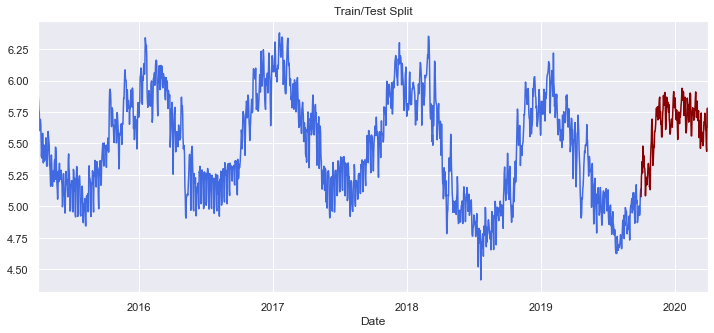

In [63]:
#@title Plot splits
plt.title('Train/Test Split')
train.plot(color='royalblue', figsize=(12, 5))
test.plot(color='darkred')
plt.show()

#### Baseline Model
*   Fit SARIMAX baseline model with default differencing for parameters p, d, q. 
*   Perform Grid Search: Auto-arima find optimal parameters within param space. 
*   Compute Test Performance Metrics

In [ ]:
# Define SARIMAX model config, instantiate.
s_model = pm.auto_arima(train, start_p=0, d=1, start_q=0,
                        max_p=6, max_q=6, m=21,
                        seasonal=True, stationary=False,
                        information_criterion='aic',
                        stepwise=False,
                        suppress_warnings=True)
# Fit to train
fit_model = s_model.fit(train)

# Get model summary 
summary = fit_model.summary()

In [56]:
#@title Fit Baseline Model
# Instantiate SARIMAX model.
model = SARIMAX(
    train,
    order=(0,0,1), # p,d,q differencing parameters
    seasonal_order=(1,0,1,182), # (P,D,Q,M) Seasonal components
    simple_differencing=True,
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend = 'c') 

    # order=(0,0,1), # p,d,q differencing parameters
    # seasonal_order=(1,0,1,100), # (P,D,Q,M) Seasonal components

# Fit SARIMAX model
fitted_model = model.fit() 

# Get predictions
y_pred = fitted_model.predict(test.index[0], 
                              test.index[-1], 
                              typ='levels') \
                     .rename('y_pred')
 

In [57]:
#@title Compute Model Performance
results = _ModelTrainingBase.make_pred_results_dataframe(test, y_pred)

# Compute Root Mean Squared Error
rmse = _ModelTrainingBase.rmse(y_pred, test)
# rss = sum((fitted_model.fittedvalues - train)**2)

Text(0.5, 1.0, 'SARIMAX TEST PERFORMANCE, RMSE:0.23')

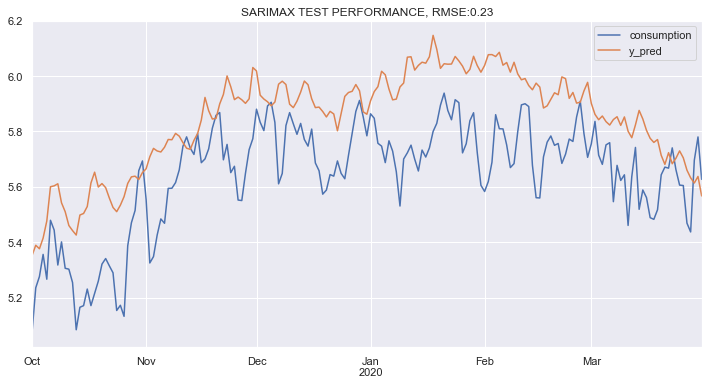

In [58]:
#@title Plot Results
results.plot(figsize=(12,6))
plt.title(f'SARIMAX TEST PERFORMANCE, RMSE:{rmse:.2f}')

#### Primary Model

*   Fit production forecast model to all available training data.
*   Create exogenous regressors in at attempt to improve model fit. 
*   Re-search parameter space.
*   Perform forecast.



In [66]:
#@title Create endogenous features dataframe
endogenous_feats_df = ModelTraining(df).compute_features()
endogenous_feats_df = endogenous_feats_df.dropna()

,feat__consumption__roc__28__0,feat__consumption__roc__93__0,feat__consumption__roc__180__0,feat__consumption__roc__28__1,feat__consumption__roc__93__1,feat__consumption__roc__180__1,feat__consumption__roc__28__2,feat__consumption__roc__93__2,feat__consumption__roc__180__2,feat__consumption__roc__28__3,feat__consumption__roc__93__3,feat__consumption__roc__180__3
Date,,,,,,,,,,,,
2015-09-30,0.103879,0.351744,-0.244696,0.198704,0.358575,-0.252095,0.300284,0.693977,-0.281881,0.057196,0.430836,-0.427590
2015-10-01,0.182228,0.315673,-0.115763,0.103879,0.351744,-0.244696,0.198704,0.358575,-0.252095,0.300284,0.693977,-0.281881
2015-10-02,0.356509,0.321808,-0.171846,0.182228,0.315673,-0.115763,0.103879,0.351744,-0.244696,0.198704,0.358575,-0.252095
2015-10-03,0.276640,0.231052,-0.254030,0.356509,0.321808,-0.171846,0.182228,0.315673,-0.115763,0.103879,0.351744,-0.244696
2015-10-04,-0.004017,0.416006,-0.291372,0.276640,0.231052,-0.254030,0.356509,0.321808,-0.171846,0.182228,0.315673,-0.115763
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,-0.211530,-0.217071,0.393427,-0.171392,-0.024150,0.667117,-0.261502,-0.041377,0.894975,-0.173111,-0.030894,1.080888
2020-03-28,-0.272598,-0.299954,0.434806,-0.211530,-0.217071,0.393427,-0.171392,-0.024150,0.667117,-0.261502,-0.041377,0.894975
2020-03-29,-0.130975,-0.161813,0.585076,-0.272598,-0.299954,0.434806,-0.211530,-0.217071,0.393427,-0.171392,-0.024150,0.667117


In [70]:
# Training data 
train_df = pd.concat([df, endogenous_feats_df], axis=1, join='inner')
target = train_df.pop('consumption')

In [71]:
# Fit model 
model = SARIMAX(
    target,
    exog = train_df,
    order=(0,0,1), 
    seasonal_order=(1,0,1,182),
    simple_differencing=True,
    enforce_stationarity=False,
    enforce_invertibility=False) 

# Fit SARIMAX model
fitted_model = model.fit() 

In [72]:
# Fitted model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         consumption   No. Observations:                 1645
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 182)   Log Likelihood               -6921.318
Date:                             Sat, 27 Aug 2022   AIC                          13874.637
Time:                                     11:01:41   BIC                          13959.227
Sample:                                 09-30-2015   HQIC                         13906.191
                                      - 03-31-2020                                         
Covariance Type:                               opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
feat__consumption__roc__28__0     83.0083      5.003     16.592      0.000      73.203      92.814
feat__consumption__roc__93__0     34.0937      3.987      8.550      0.000      26.278      41.909
feat__consumption__roc__180__0    82.7660      2.985     27.727      0.000      76.915      88.617
feat__consumption__roc__28__1    -29.3162      5.716     -5.129      0.000     -40.519     -18.114
feat__consumption__roc__93__1     10.8045      4.058      2.662      0.008       2.851      18.758
feat__consumption__roc__180__1     0.2260      3.184      0.071      0.943      -6.014       6.466
feat__consumption__roc__28__2    -12.5575      5.681     -2.210      0.027     -23.692      -1.423
feat__consumption__roc__93__2     -5.8003      3.943     -1.471      0.141     -13.528       1.928
feat__consumption__roc__180__2   -13.2888      2.941     -4.518      0.000     -19.053      -7.524
feat__consumption__roc__28__3     11.0913      5.660      1.960      0.050      -0.002      22.185
feat__consumption__roc__93__3    -60.5001      3.998    -15.131      0.000     -68.337     -52.663
feat__consumption__roc__180__3    46.0706      2.978     15.470      0.000      40.234      51.908
ma.L1                              0.7836      0.016     48.038      0.000       0.752       0.816
ar.S.L182                          0.9580      0.002    396.456      0.000       0.953       0.963
ma.S.L182                         -0.7708      0.042    -18.550      0.000      -0.852      -0.689
sigma2                           679.1988     30.147     22.530      0.000     620.112     738.286
===================================================================================
Ljung-Box (L1) (Q):                 206.21   Jarque-Bera (JB):                59.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Get forecast
forecast_start = df.index[-1]
forecast_end = pd.to_datetime(
    pd.date_range(
        forecast_start, 
        periods=FORECAST_HORIZON, 
        freq='D')
    )


forecast = fitted_model.predict(forecast_start, 
                                forecast_end[-1],
                                exog=train_df.iloc[-365:, :], # Forecast with most recent exogenous observations
                                typ='levels').rename('Forecast')

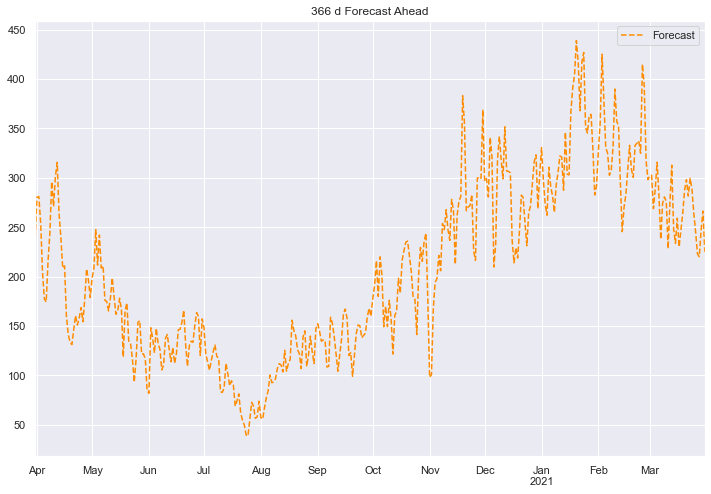

In [91]:
# Forecast 
forecast.plot(
    figsize=(12, 8), 
    linestyle='--',
    color='darkorange')
plt.title(f'{FORECAST_HORIZON} d Forecast Ahead')
plt.legend()

#### Primary Model Forecast

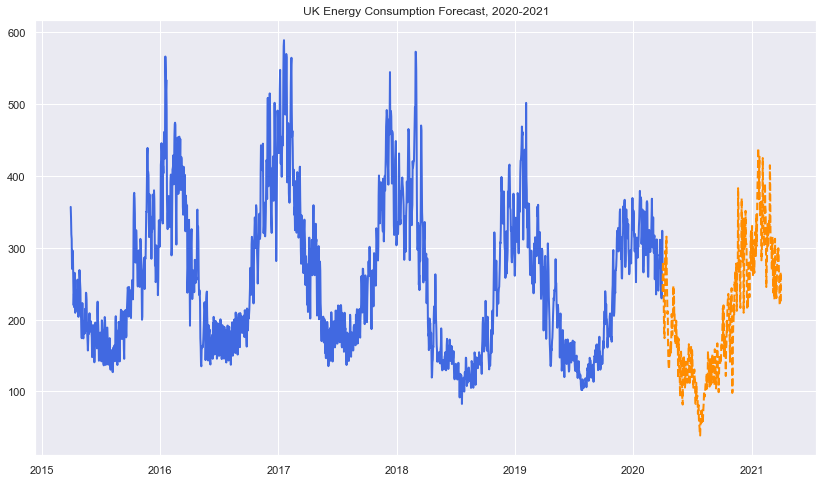

In [94]:
#@title Plot Forecast
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df, label='Energy Consumption',color='royalblue', lw=2.)
ax.plot(
    forecast, 
    label=f'Consumption {FORECAST_HORIZON}d Forecast',
    color='darkorange',
    lw=2., linestyle='--'
)
ax.set_title('UK Energy Consumption Forecast, 2020-2021')
plt.show()